In [38]:
import requests

file_url = 'https://huggingface.co/datasets/Smulemun/music2image/resolve/main/data.zip?download=true'
file_name = 'data.zip' 

# Download the file
response = requests.get(file_url)

if response.status_code == 200:
    # Save the file to your local machine
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f"The file {file_name} has been downloaded.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

The file data.zip has been downloaded.


In [40]:
import zipfile
import os

def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Example usage:
zip_file_path = 'data.zip'
extract_to = 'data'

unzip_file(zip_file_path, extract_to)

In [337]:
from torch.utils.data import Dataset
import audio2numpy as a2n
import cv2
from tqdm import tqdm
import wav2clip as w2c
import numpy as np

IMAGE_PATH = 'data/data/images/'
MUSIC_PATH = 'data/data/music/'
IMAGE_SIZE = 128

class MusicImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.w2c_model = w2c.get_model() 
        self._load()

    def _load(self):
        self.data = []
        pbar = tqdm(self.dataframe.iterrows(), total=len(self.dataframe), desc='Loading data')
        for _, row in pbar:
            music_id = row['music_id']
            image_id = row['image_id']
            music_path = MUSIC_PATH + music_id + '.wav'
            image_path = IMAGE_PATH + image_id + '.jpg'
            try:
                audio_embedding = self._read_audio(music_path)
                image = self._read_img(image_path)
                self.data.append((audio_embedding, image))
            except Exception as e:
                print(e)
                print(f'Image: {image_path}')
                print(f'Audio: {music_path}')

    def _read_img(self, image_path):
        image = cv2.imread(image_path)
        resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        result = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB).transpose(2, 0, 1) / 255.0
        result = result.astype(np.float32)
        return result

    def _read_audio(self, audio_path):
        audio, sr = a2n.audio_from_file(audio_path)
        audio_embedding = w2c.embed_audio(audio, self.w2c_model)
        audio_embedding = np.squeeze(audio_embedding)
        return audio_embedding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [338]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wav2clip
import torch
import torch.nn as nn

def preprocess_dataframe(dataframe):
    dataframe = dataframe[0].str.split(' ', expand=True)
    dataframe.columns = ['music_id', 'image_id', 'matching']
    dataframe['matching'] = dataframe['matching'].astype(float)
    dataframe = dataframe.where(dataframe['matching'] > 0.5).dropna()
    dataframe = dataframe.where(dataframe['image_id'].str.contains('COCO')).dropna()
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

train_data = preprocess_dataframe(pd.read_csv('data/data/train_matching.txt', sep='\t', header=None))
val_data = preprocess_dataframe(pd.read_csv('data/data/val_matching.txt', sep='\t', header=None))
test_data = preprocess_dataframe(pd.read_csv('data/data/test_matching.txt', sep='\t', header=None))

print(f'Train data: {len(train_data)}\nValidation data: {len(val_data)}\nTest data: {len(test_data)}')

Train data: 29696
Validation data: 2273
Test data: 7249


In [339]:
train_data

music_id                     image_id  matching
0       1426-15  COCO_train2014_000000117772  0.874375
1       1840-16  COCO_train2014_000000381116  0.728462
2       1599-18    COCO_val2014_000000039106  0.959111
3        758-13  COCO_train2014_000000058630  0.851278
4         41-10  COCO_train2014_000000520750  0.620366
...         ...                          ...       ...
29691   1436-15  COCO_train2014_000000279401  0.754876
29692  2013-110  COCO_train2014_000000516265  0.965321
29693    831-19  COCO_train2014_000000493483  0.528891
29694   1719-13  COCO_train2014_000000524709  0.934575
29695   1560-19  COCO_train2014_000000574034  0.511555

[29696 rows x 3 columns]

In [340]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

IMAGE_PATH = 'data/data/images/'
MUSIC_PATH = 'data/data/music/'
IMAGE_SIZE = 128
BATCH_SIZE = 32

train_dataset = MusicImageDataset(train_data)
val_dataset = MusicImageDataset(val_data)
test_dataset = MusicImageDataset(test_data)

combined_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

train_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Loading data: 100%|██████████| 7249/7249 [02:49<00:00, 42.83it/s]


In [330]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


T = 300
betas = linear_beta_schedule(timesteps=T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Testing:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

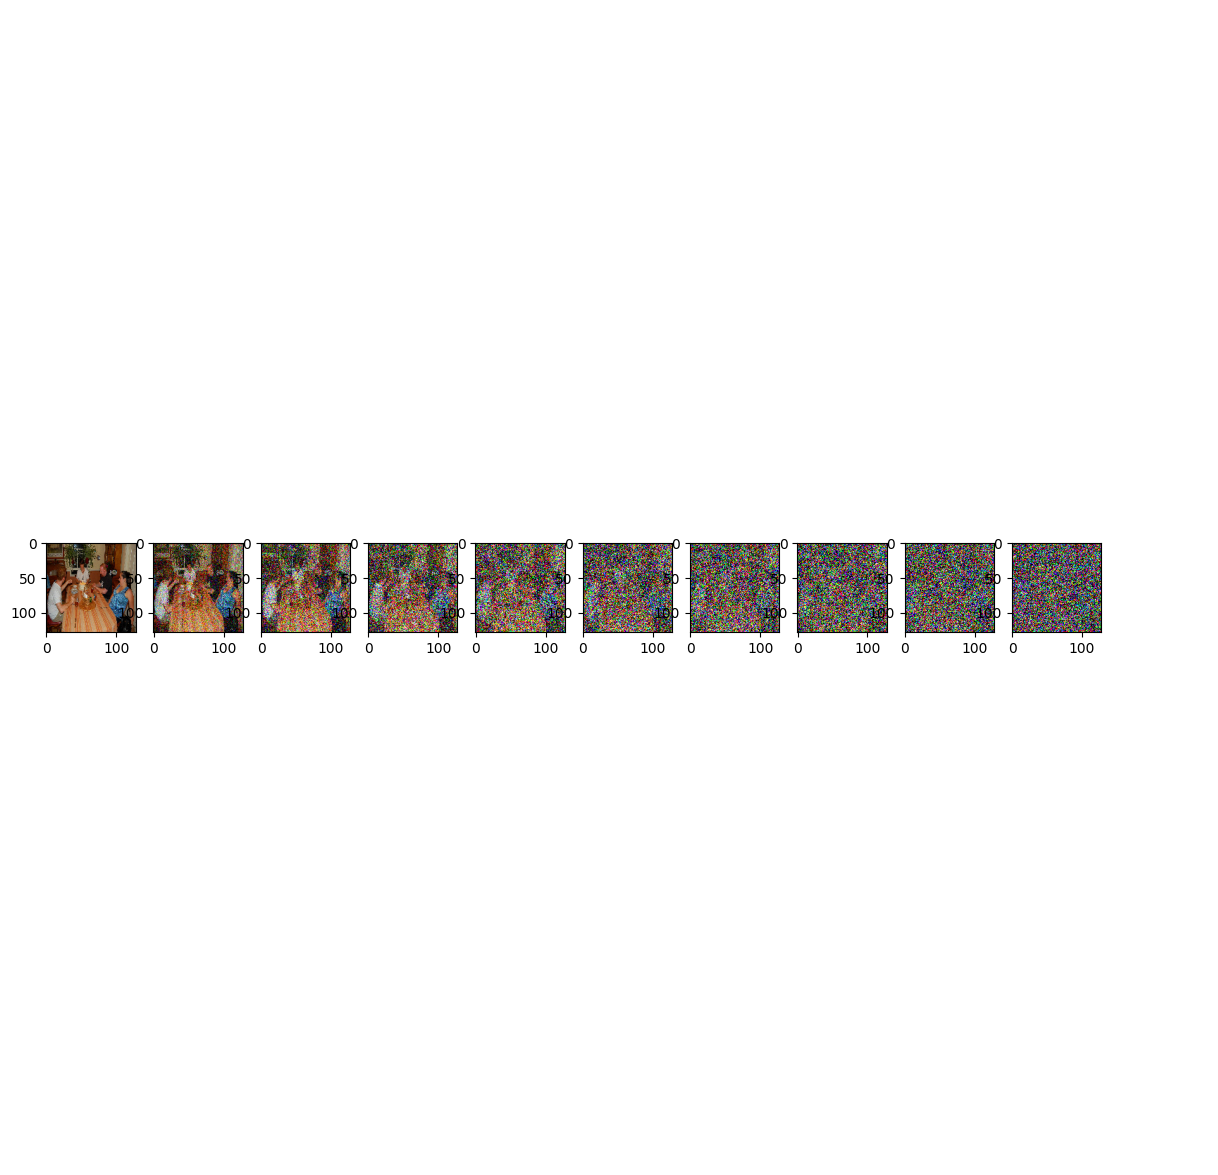

In [331]:
# Simulate forward diffusion
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = next(iter(train_loader))[1]

a = torch.randn_like(image)
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image[0], t)
    
    plt.imshow(img.permute(1,2,0))
plt.show()

In [381]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32
        music_embedding_dim = 512

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        self.music_embedding = nn.Linear(music_embedding_dim, time_emb_dim)

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep, music_embedding):
        t = self.time_mlp(timestep)
        m = self.music_embedding(music_embedding)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t + m)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t + m)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62455299


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (music_embedding): Linear(in_features=512, out_features=32, bias=True)
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128

In [382]:
def get_loss(model, x_0, t, music):
    music.to('cuda')
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t, music)
    return F.l1_loss(noise, noise_pred)

In [383]:
@torch.no_grad()
def sample_timestep(x, t, music):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # model(x, t) predict noise, then we substract noise from the image x - betas_t * model(x, t)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, music) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(music):
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    # here we do sample_timestep from T (300) to 0 we substract noise for every timestamp
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, music)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

Epoch 0 | Loss: 0.8114435076713562 


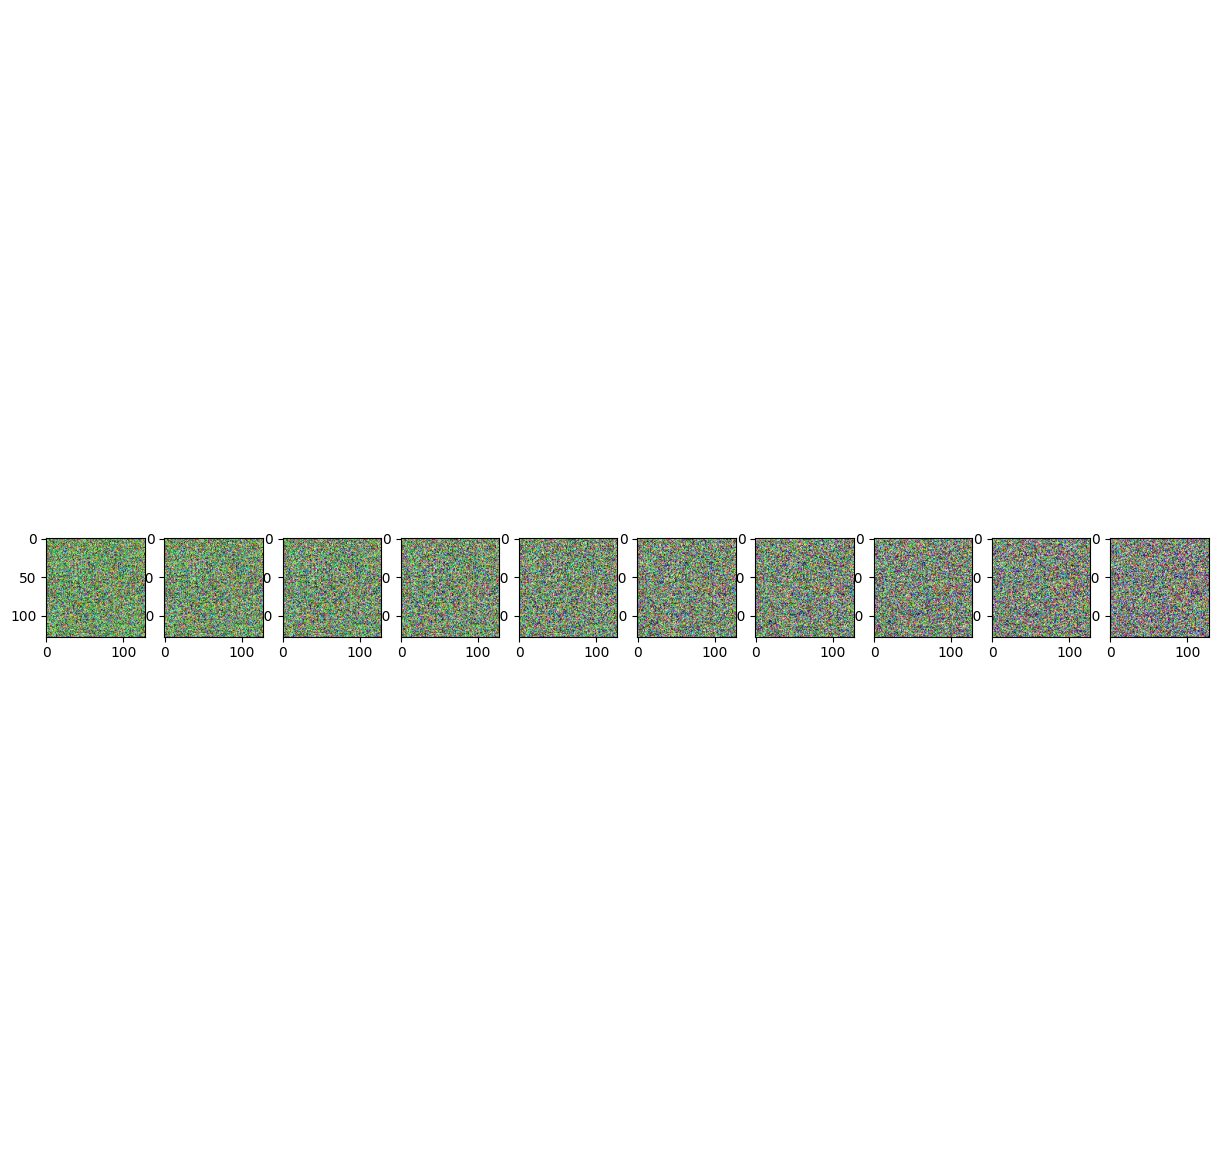

Epoch 5 | Loss: 0.09258216619491577 


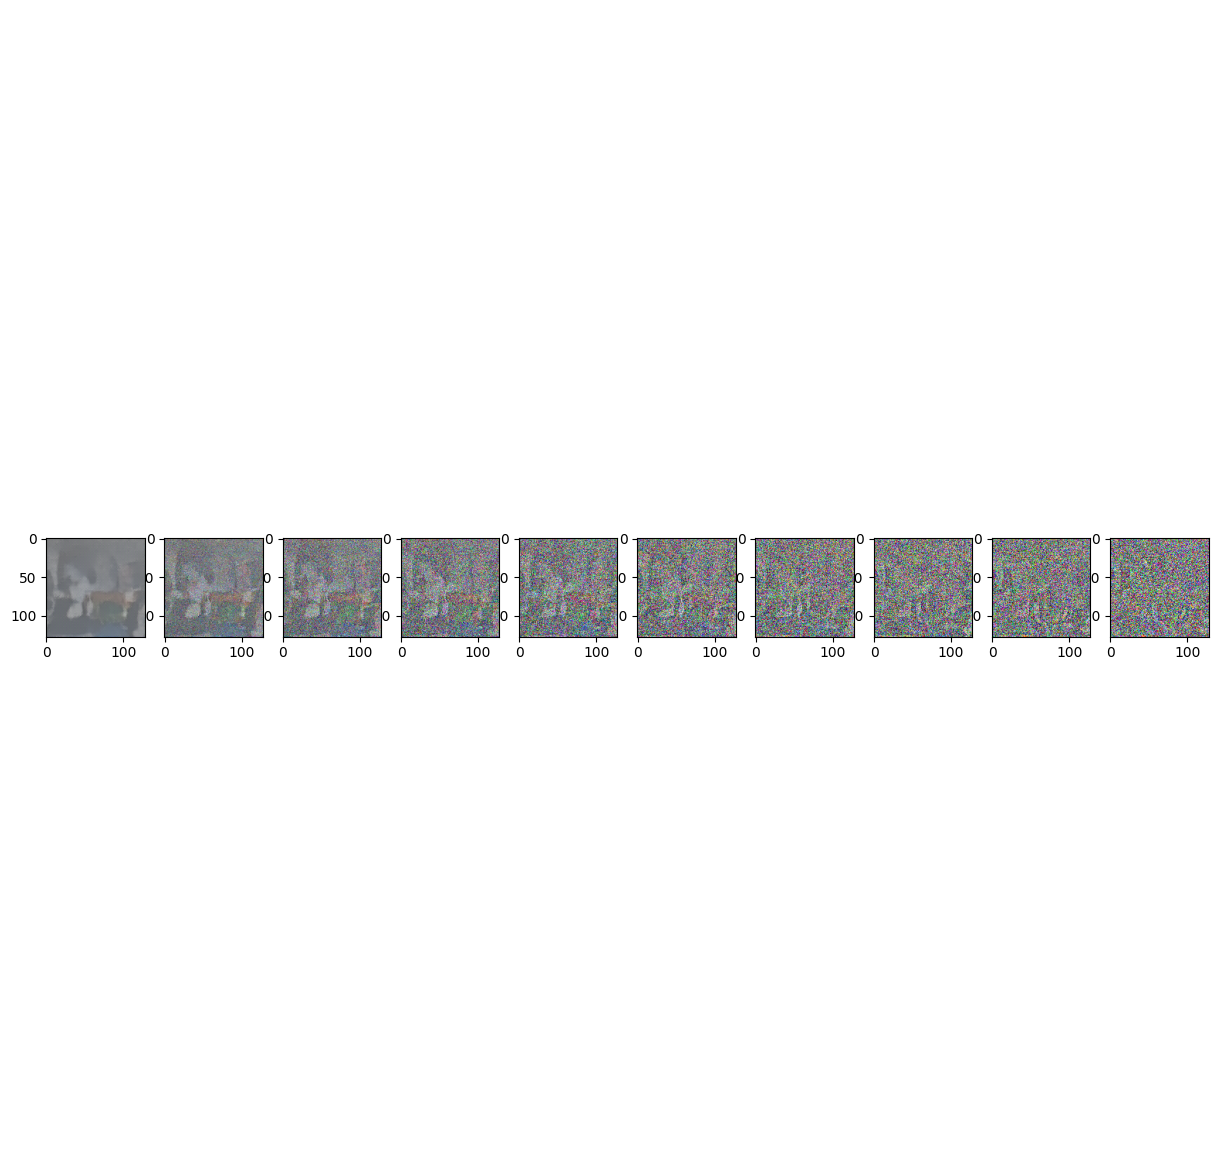

Epoch 10 | Loss: 0.1024274080991745 


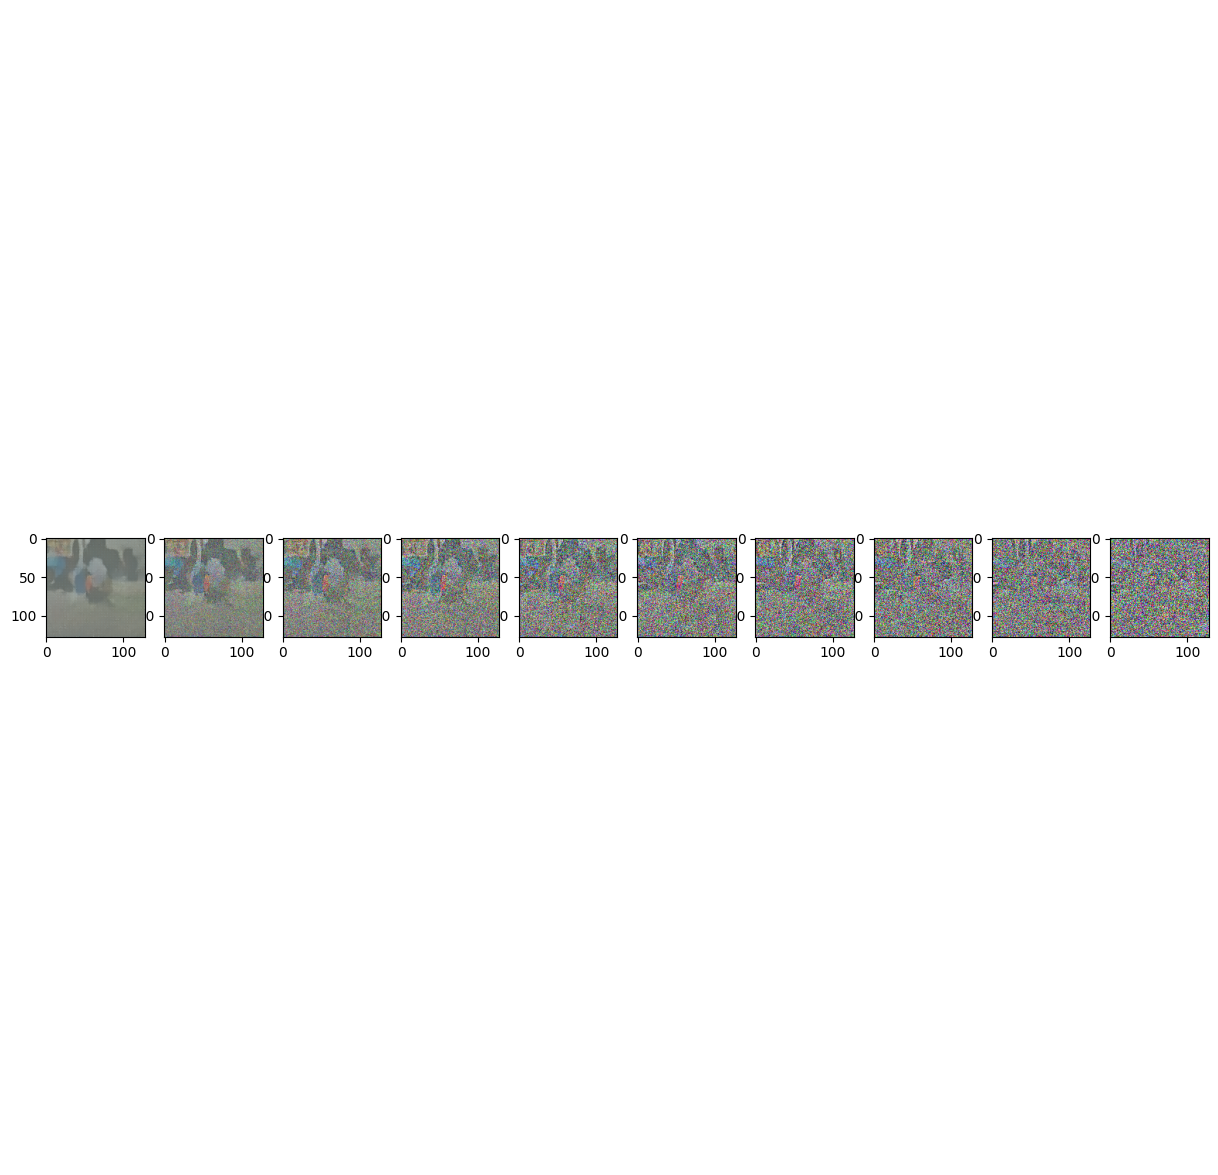

Epoch 15 | Loss: 0.10836397111415863 


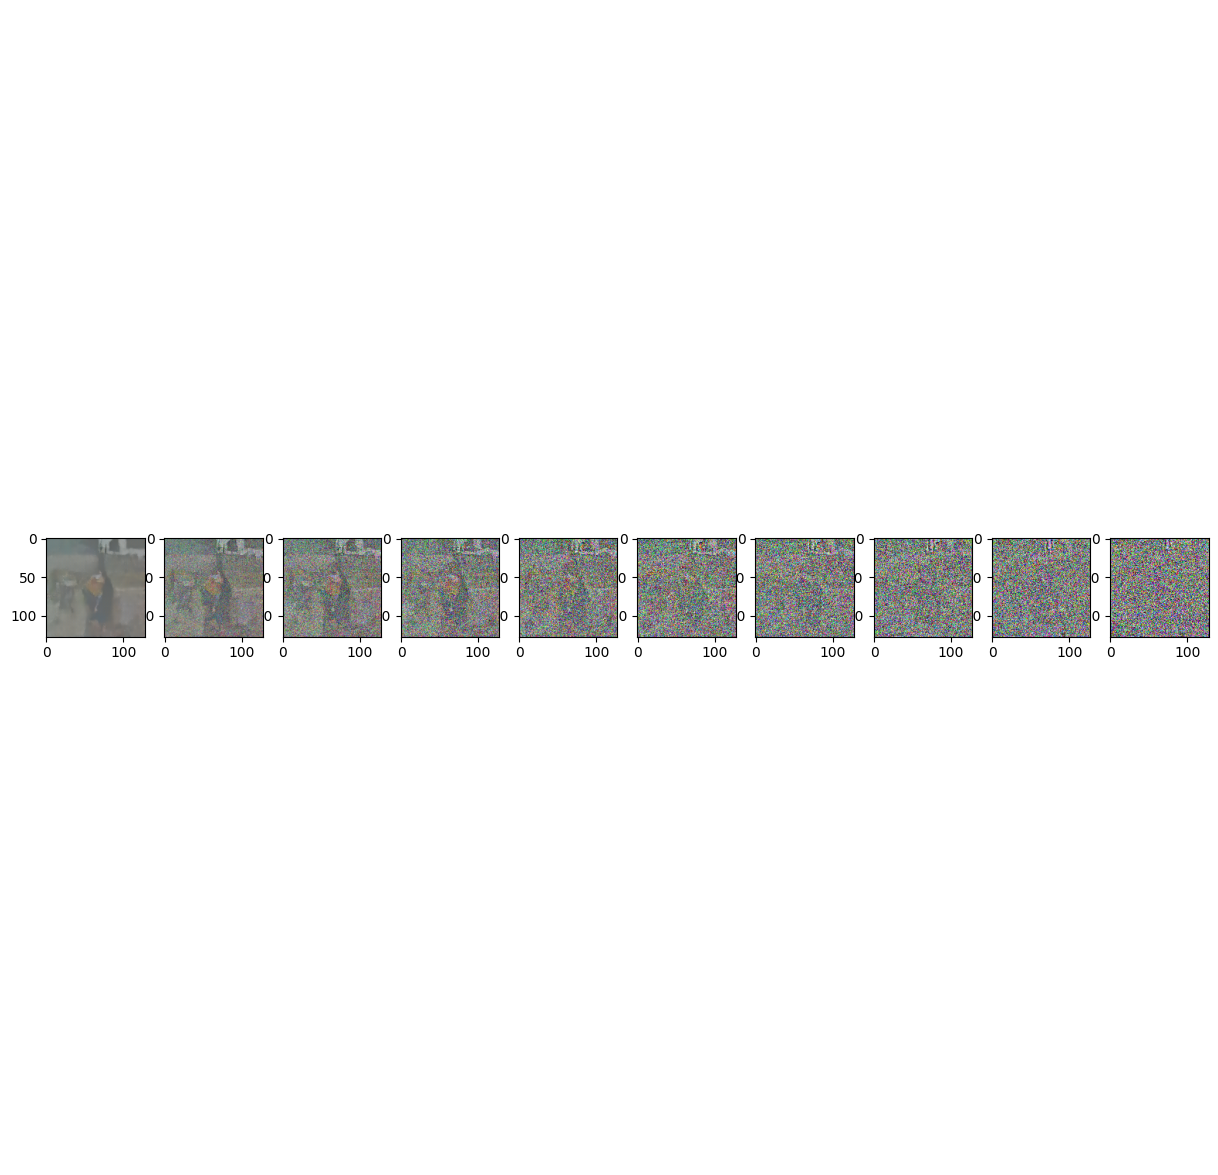

Epoch 20 | Loss: 0.11683742702007294 


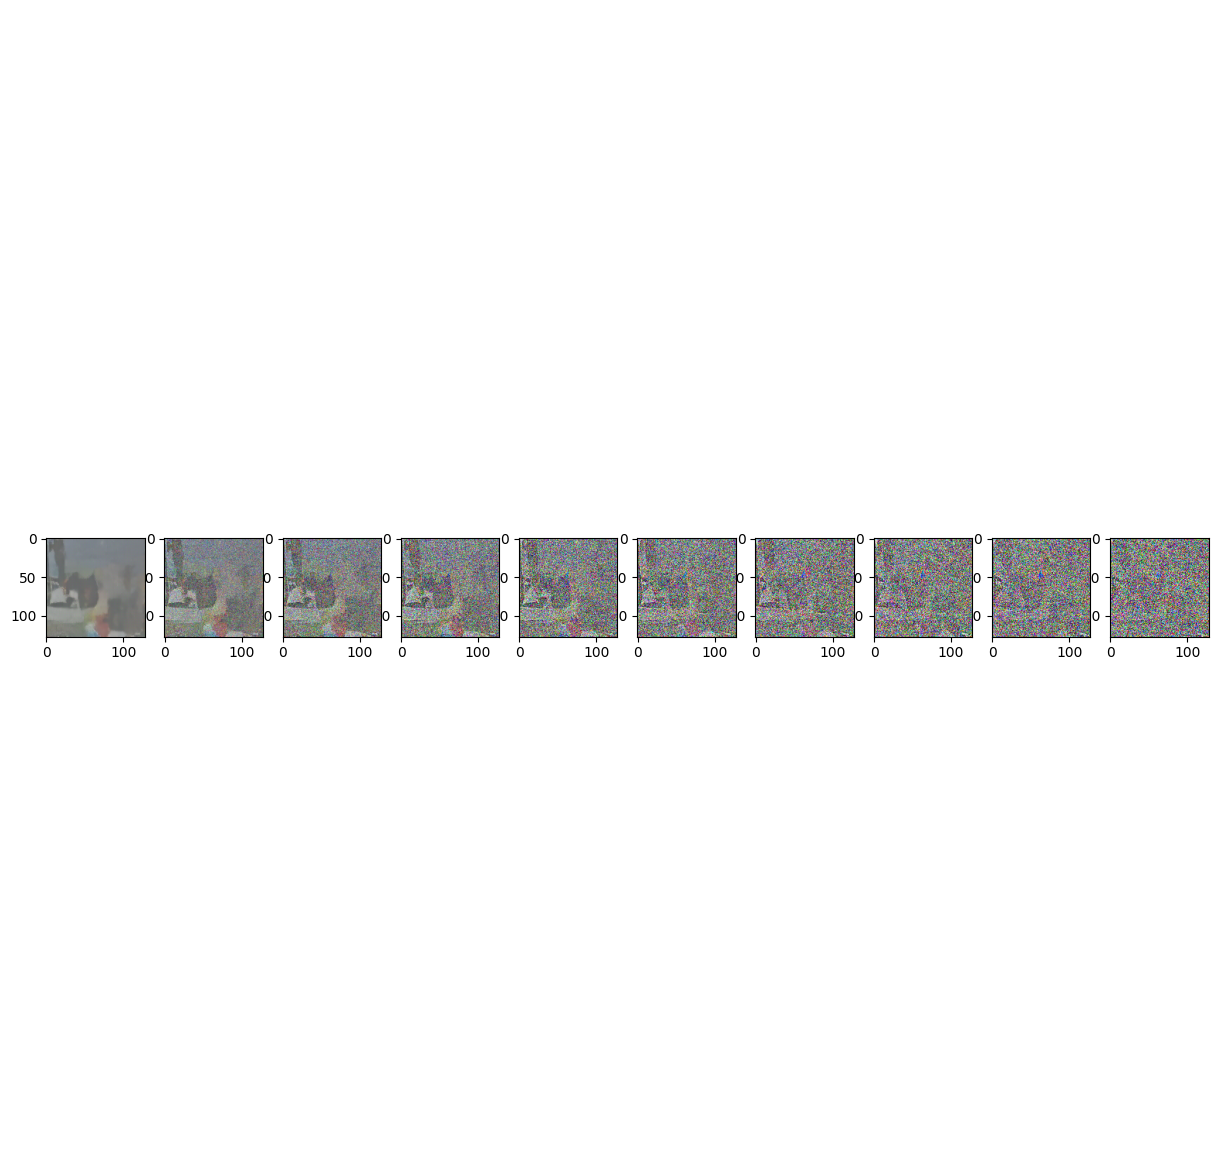

Epoch 25 | Loss: 0.1616244614124298 


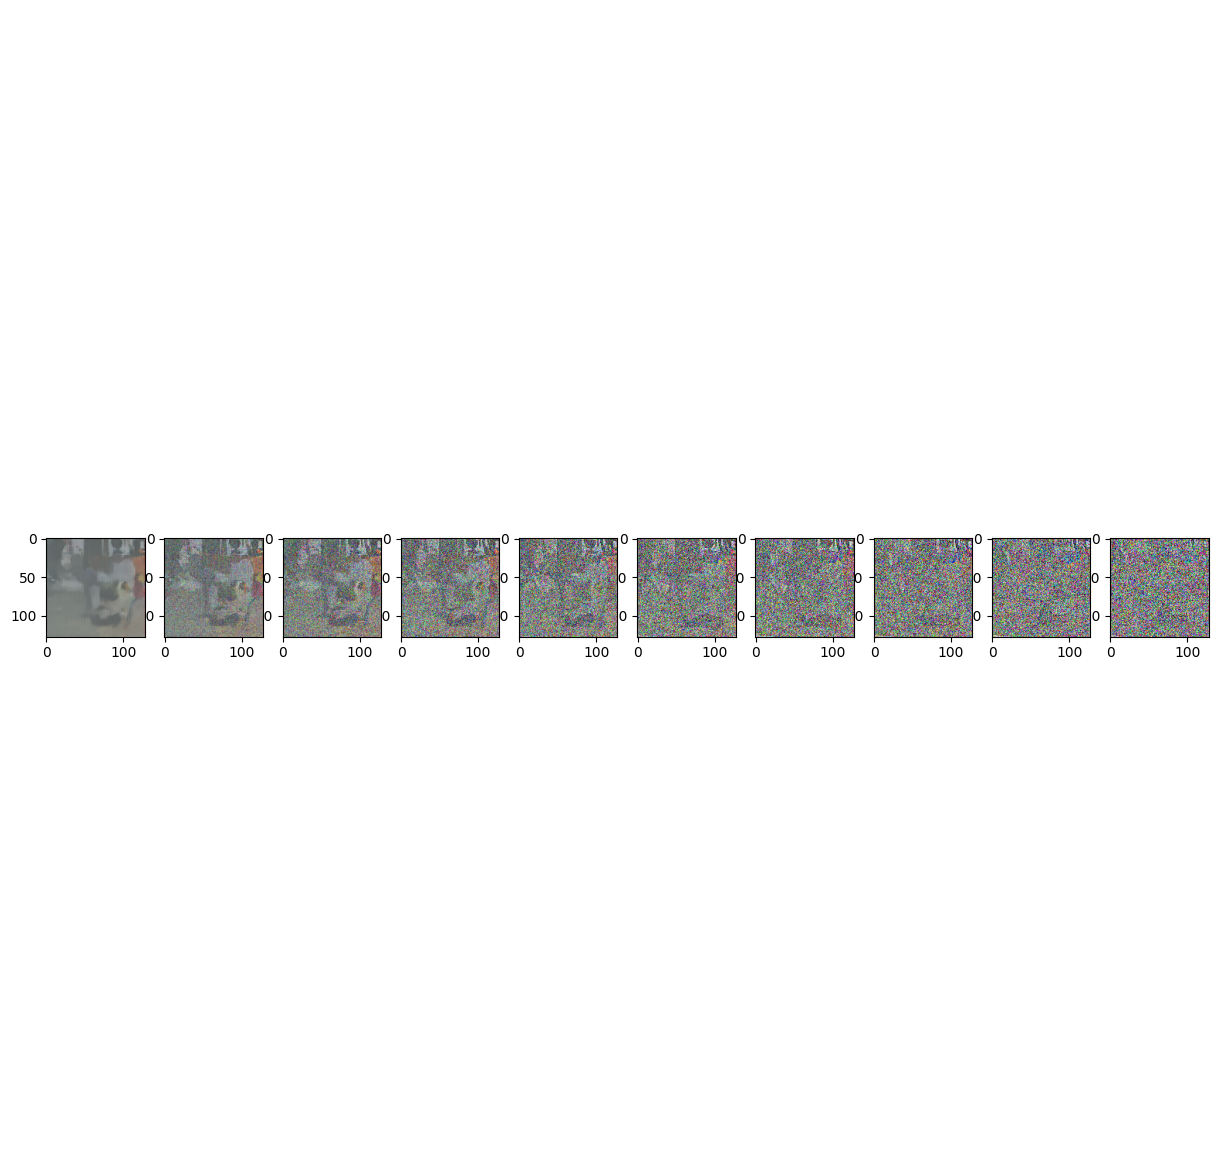

Epoch 30 | Loss: 0.1028318852186203 


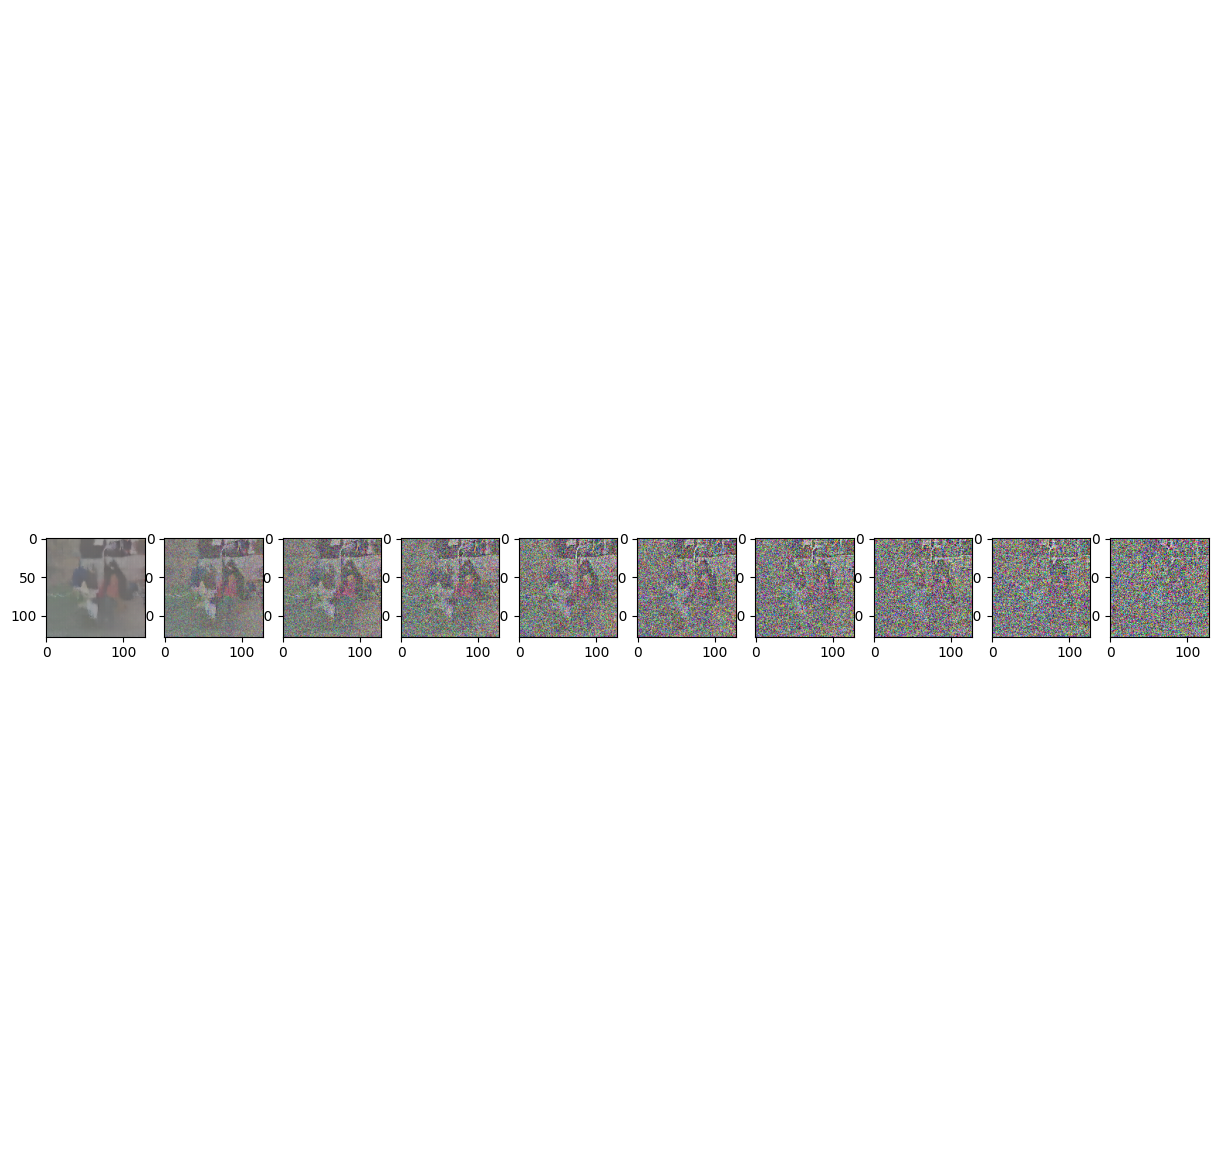

Epoch 35 | Loss: 0.09265242516994476 


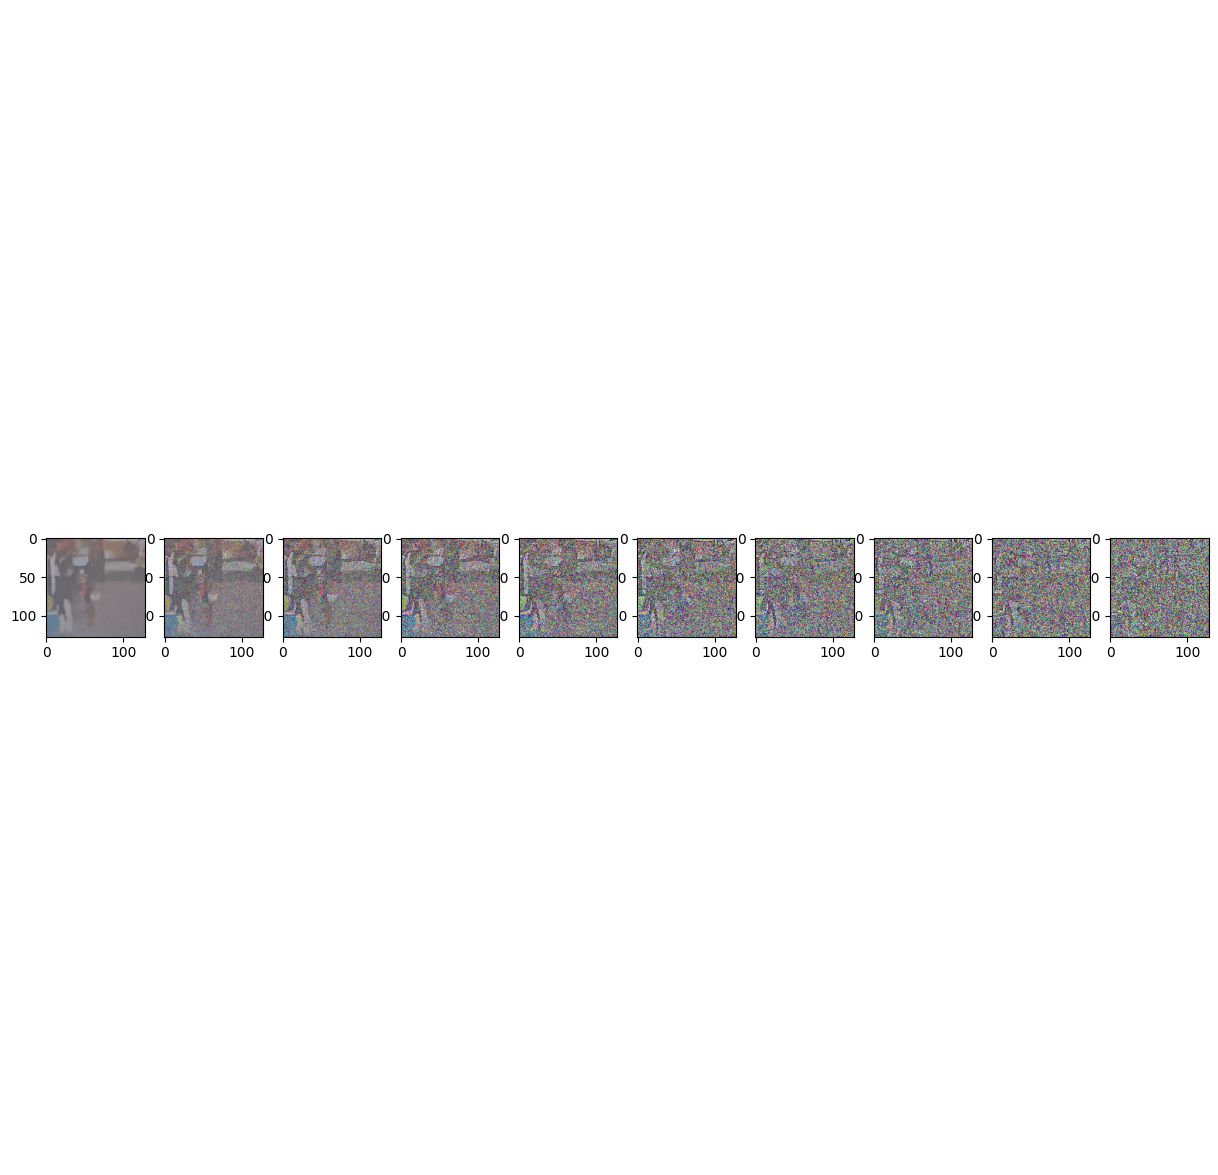

Epoch 40 | Loss: 0.11950822919607162 


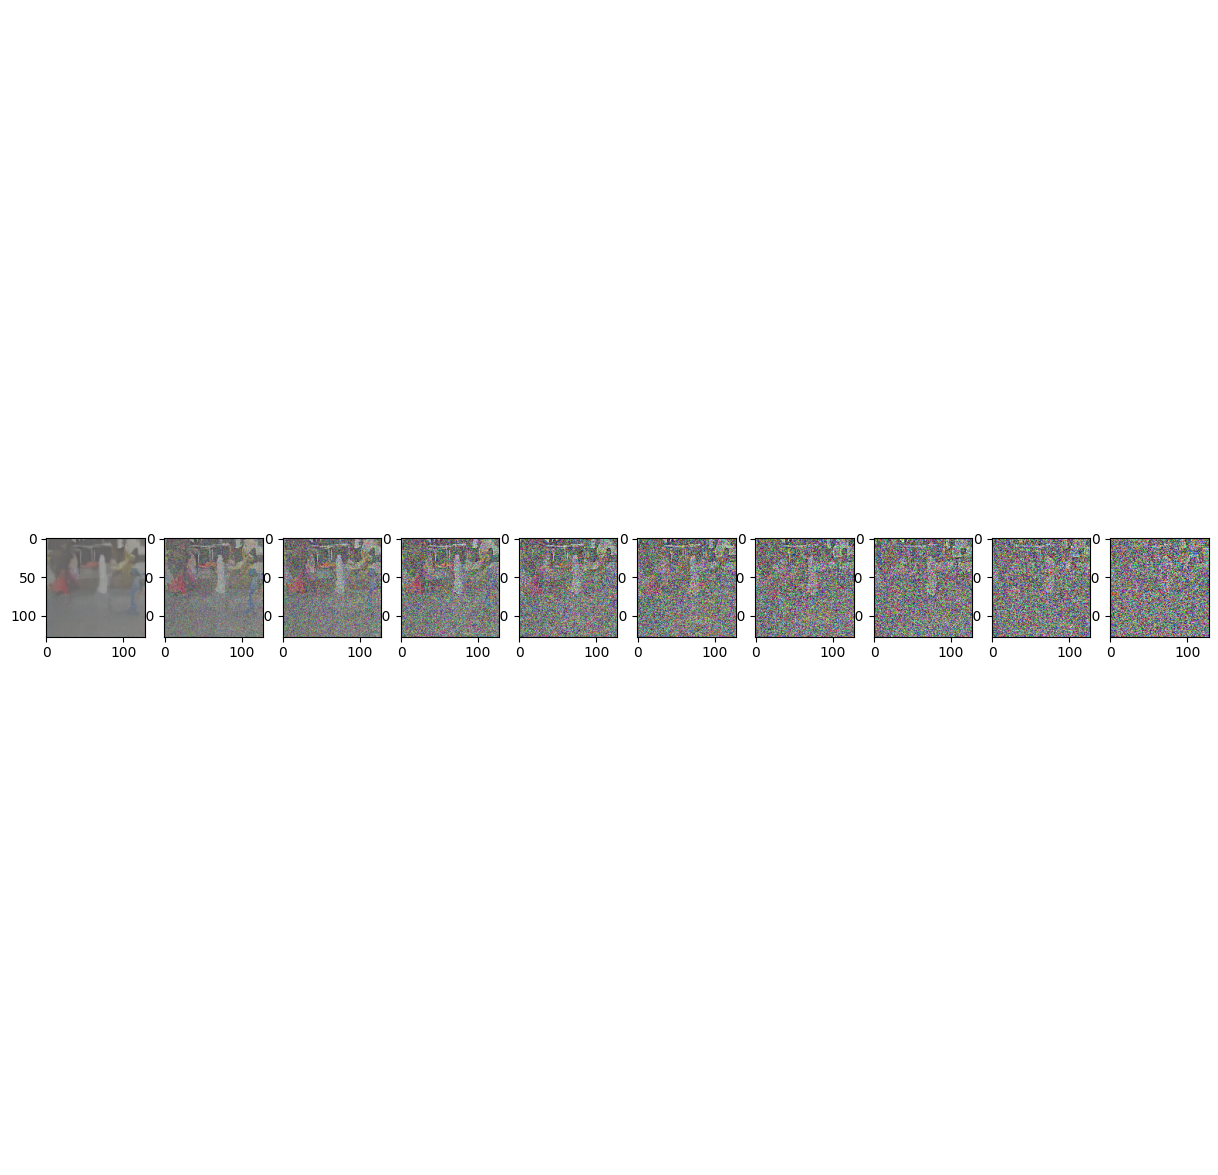

Epoch 45 | Loss: 0.1113869771361351 


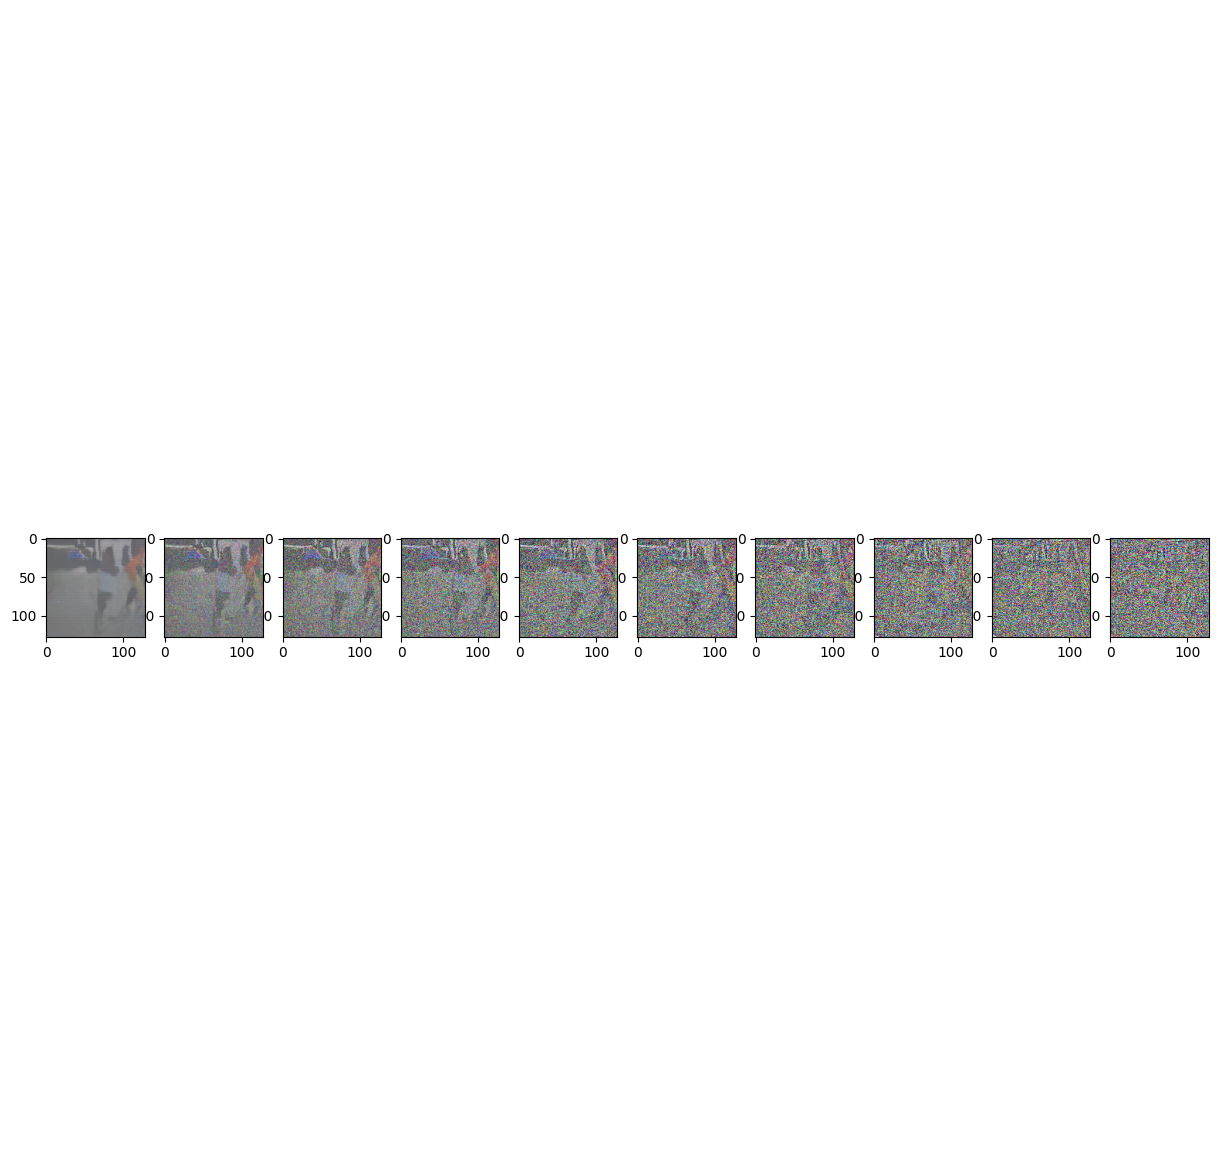

Epoch 50 | Loss: 0.12907320261001587 


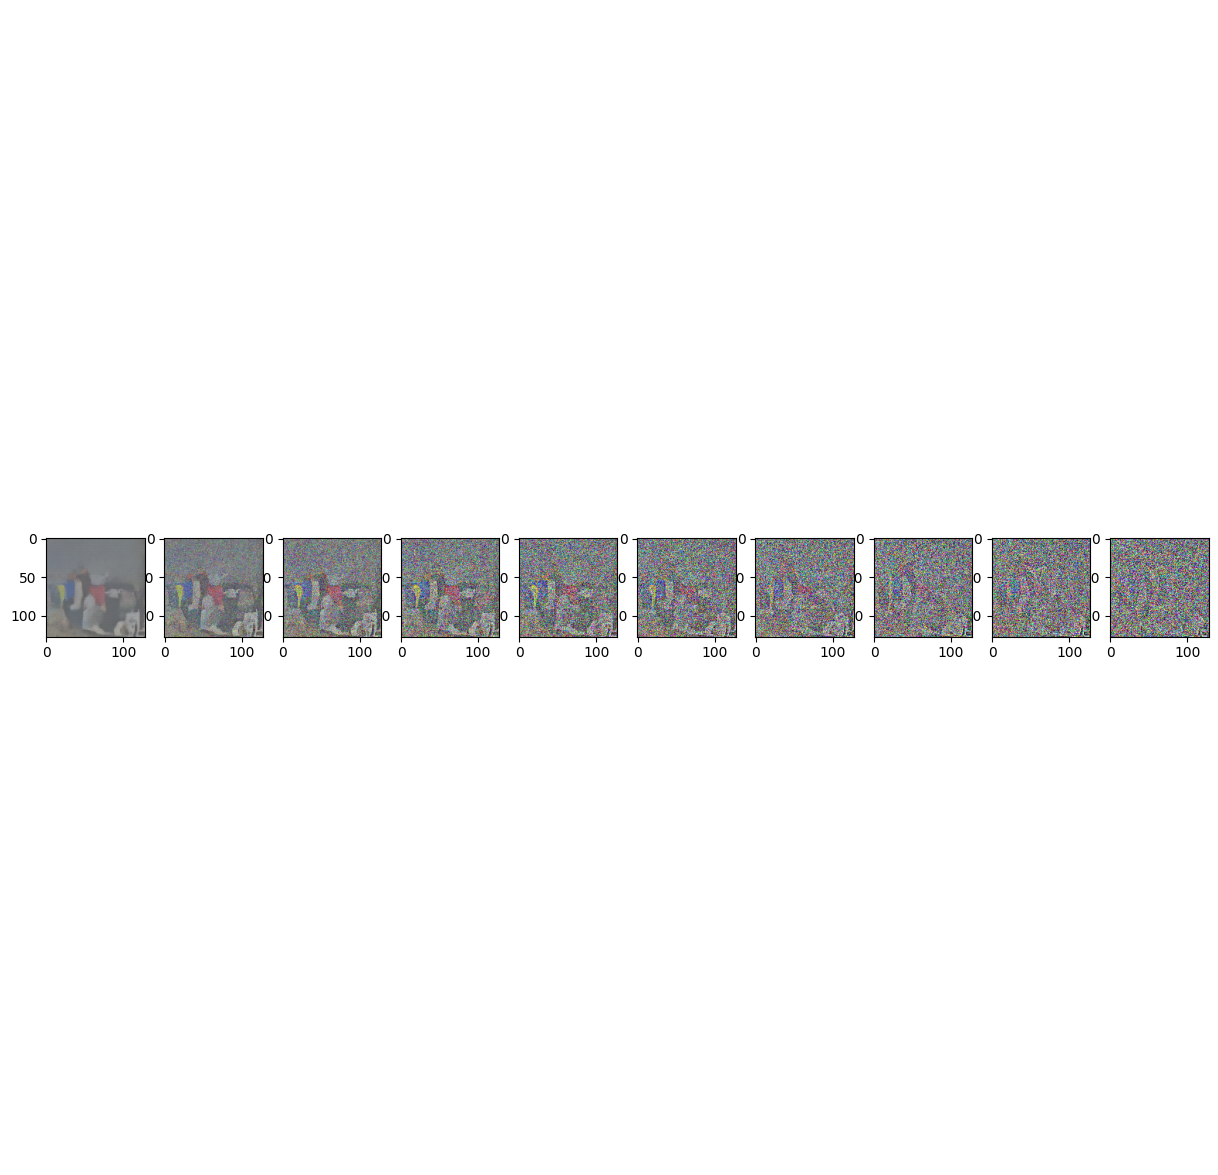

Epoch 55 | Loss: 0.11279021948575974 


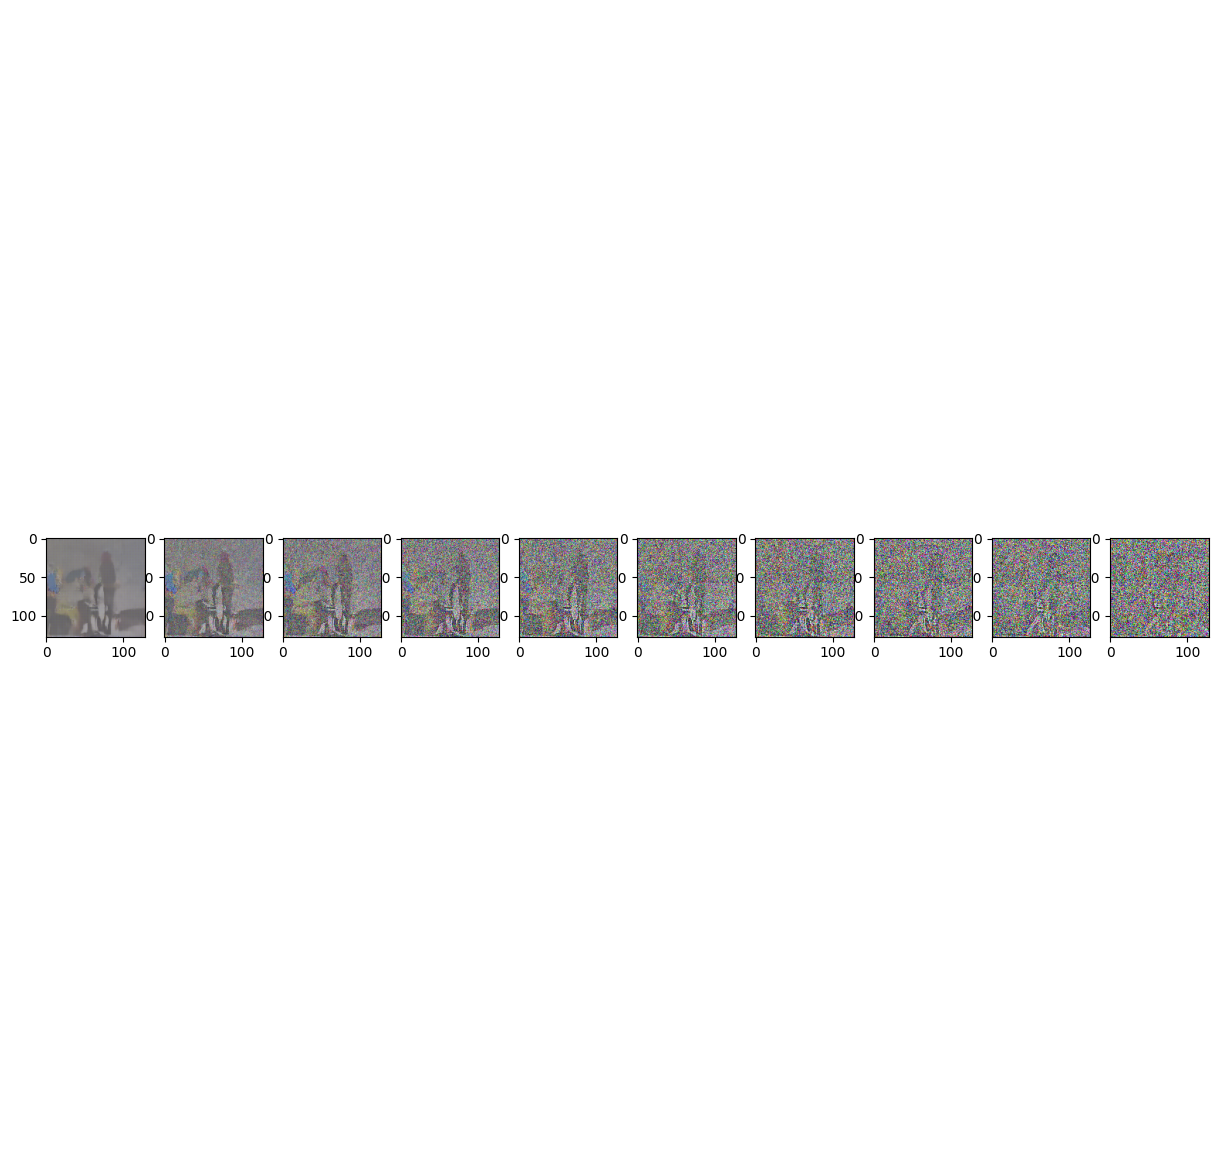

Epoch 60 | Loss: 0.14179149270057678 


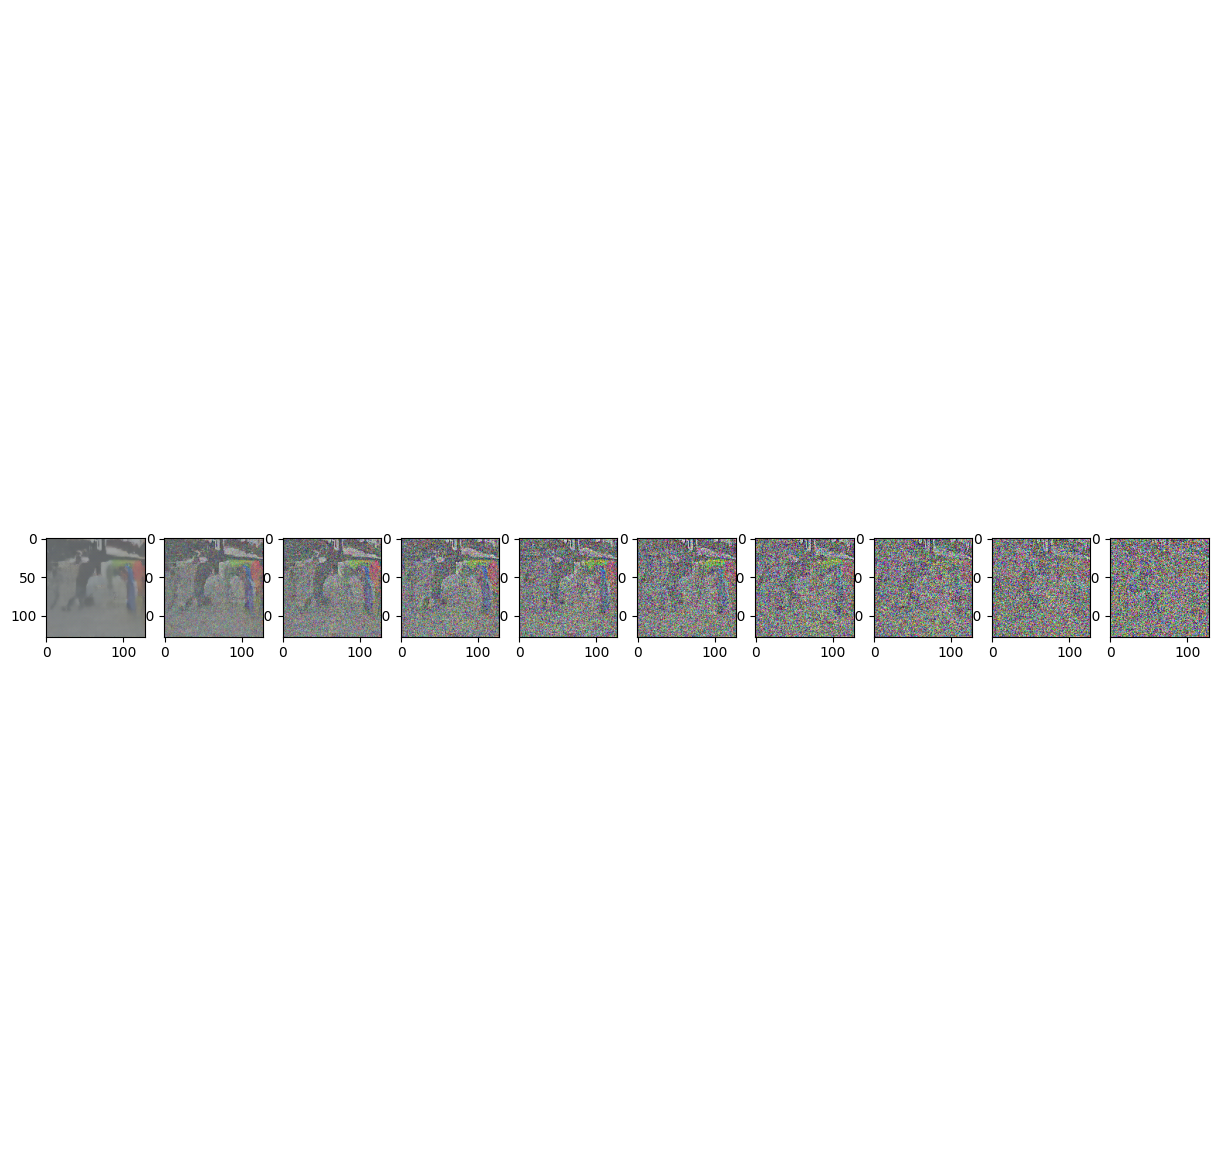

Epoch 65 | Loss: 0.11057775467634201 


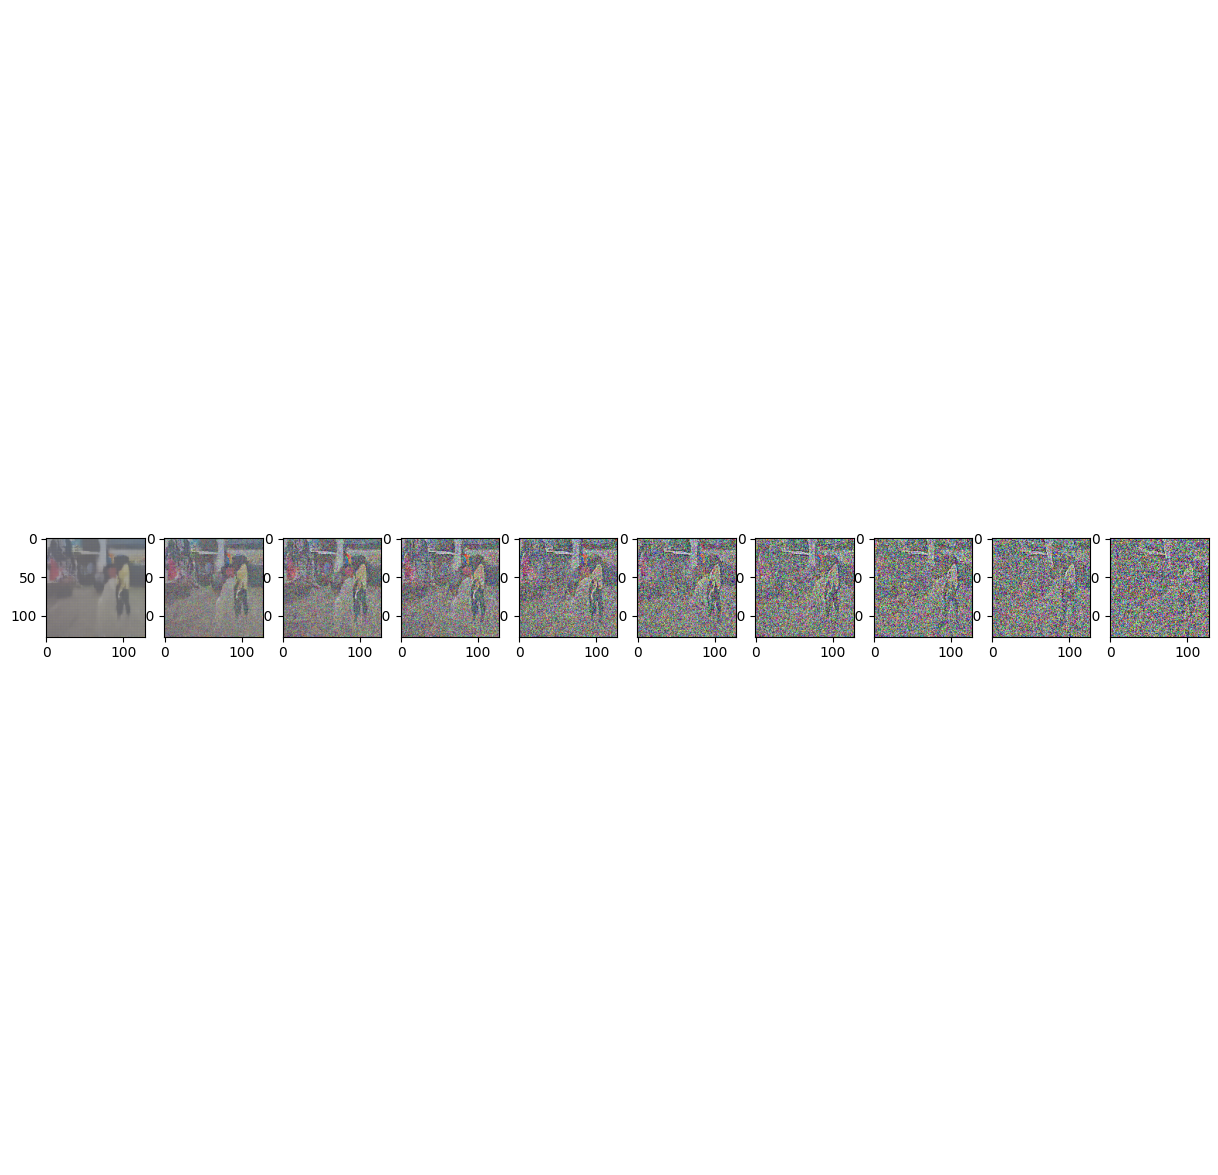

Epoch 70 | Loss: 0.07136920094490051 


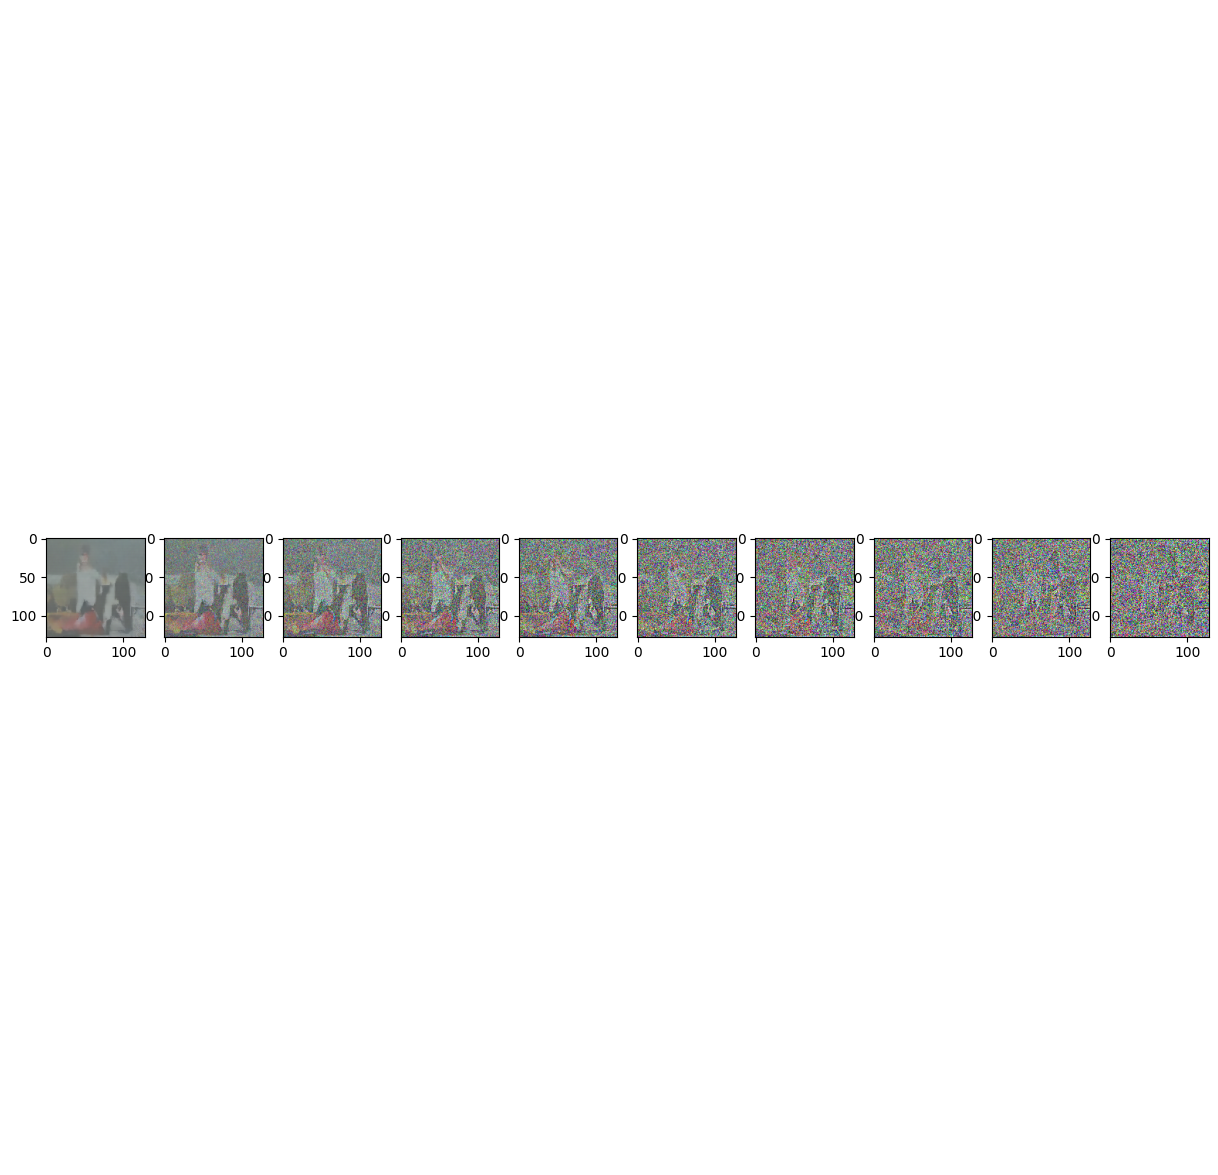

Epoch 75 | Loss: 0.11865942180156708 


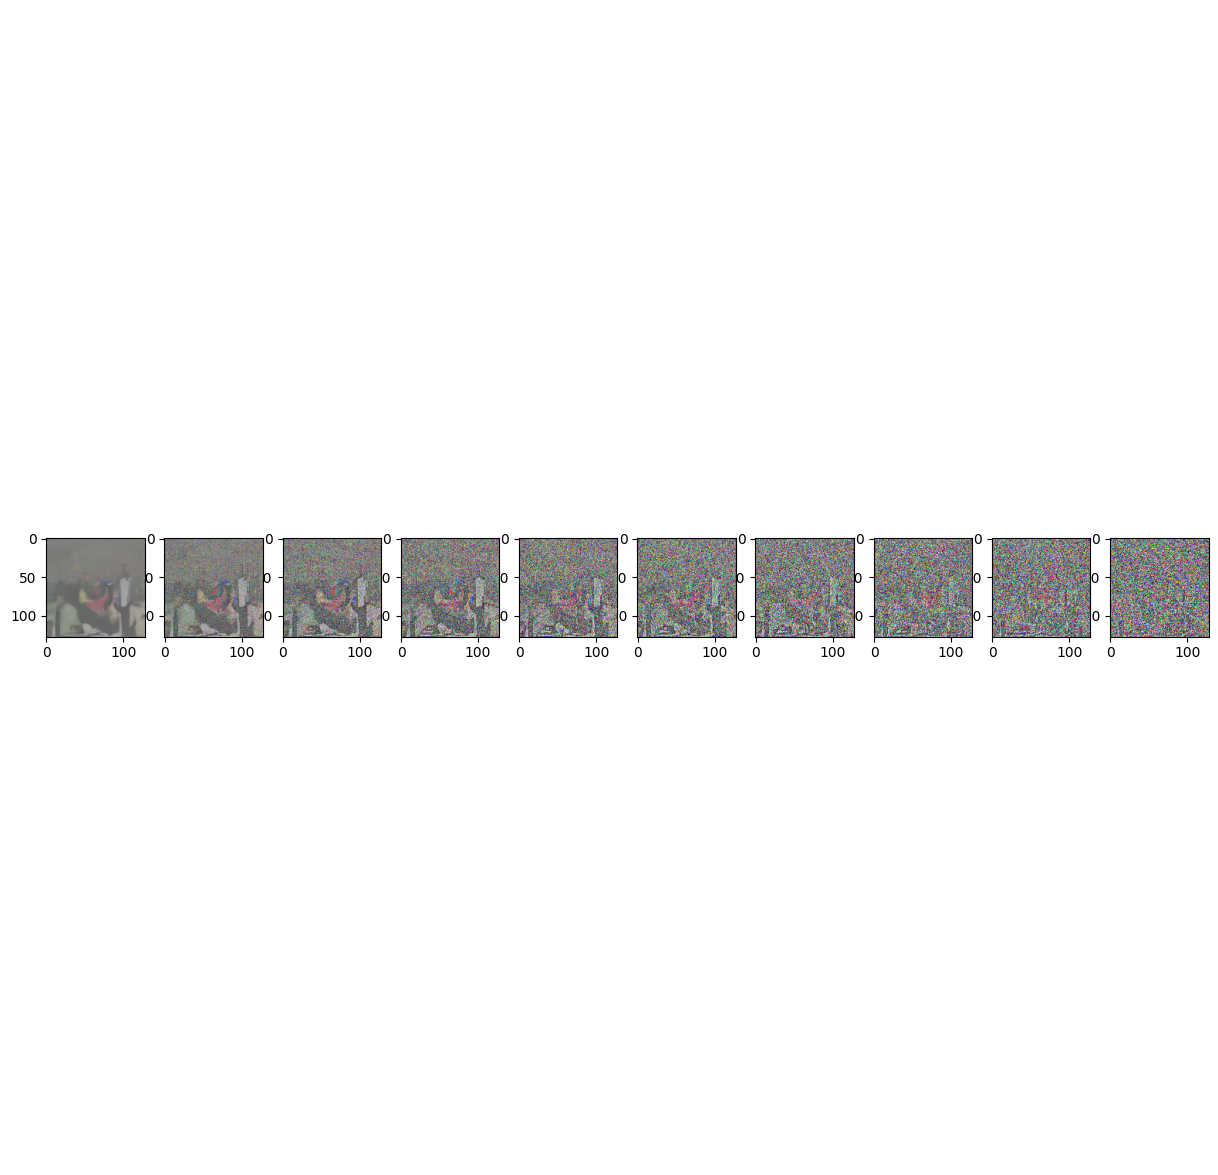

Epoch 80 | Loss: 0.10567739605903625 


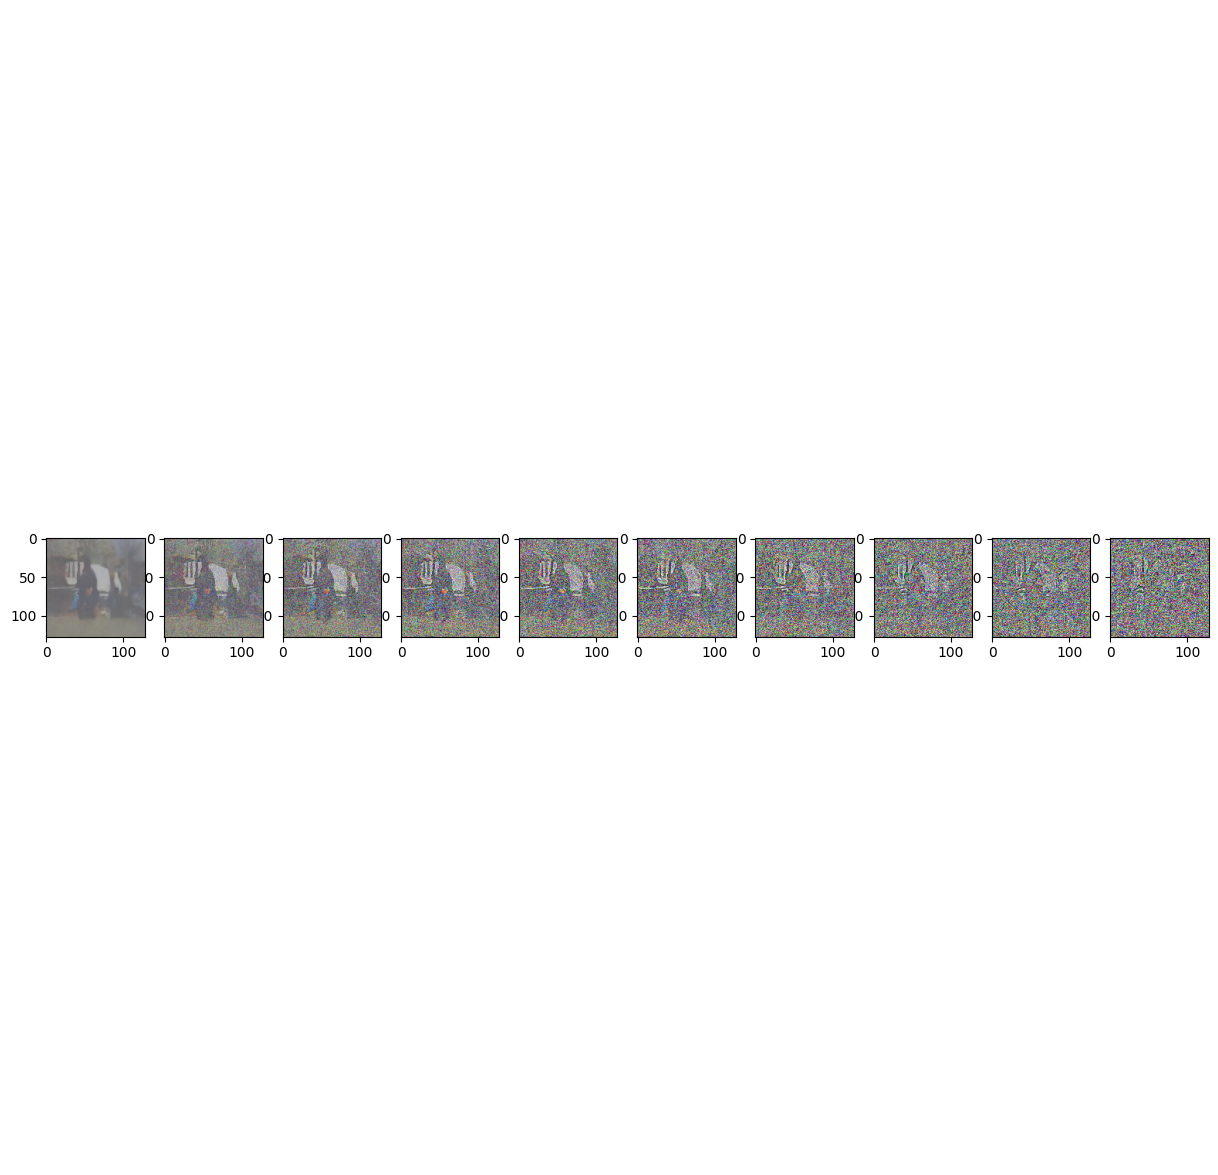

Epoch 85 | Loss: 0.11394723504781723 


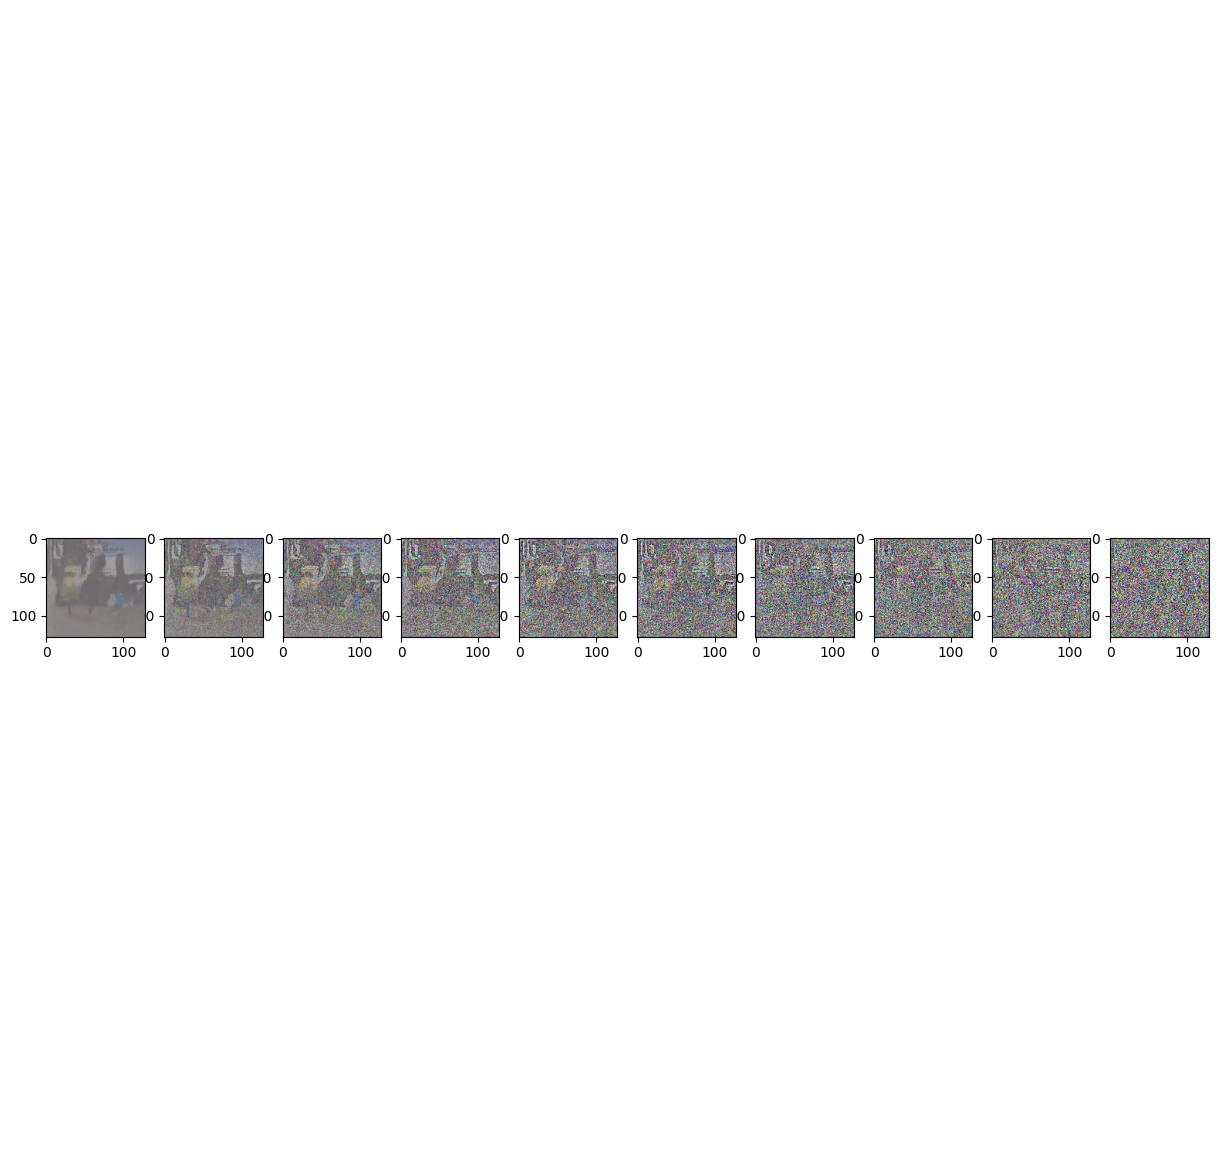

Epoch 90 | Loss: 0.10410343110561371 


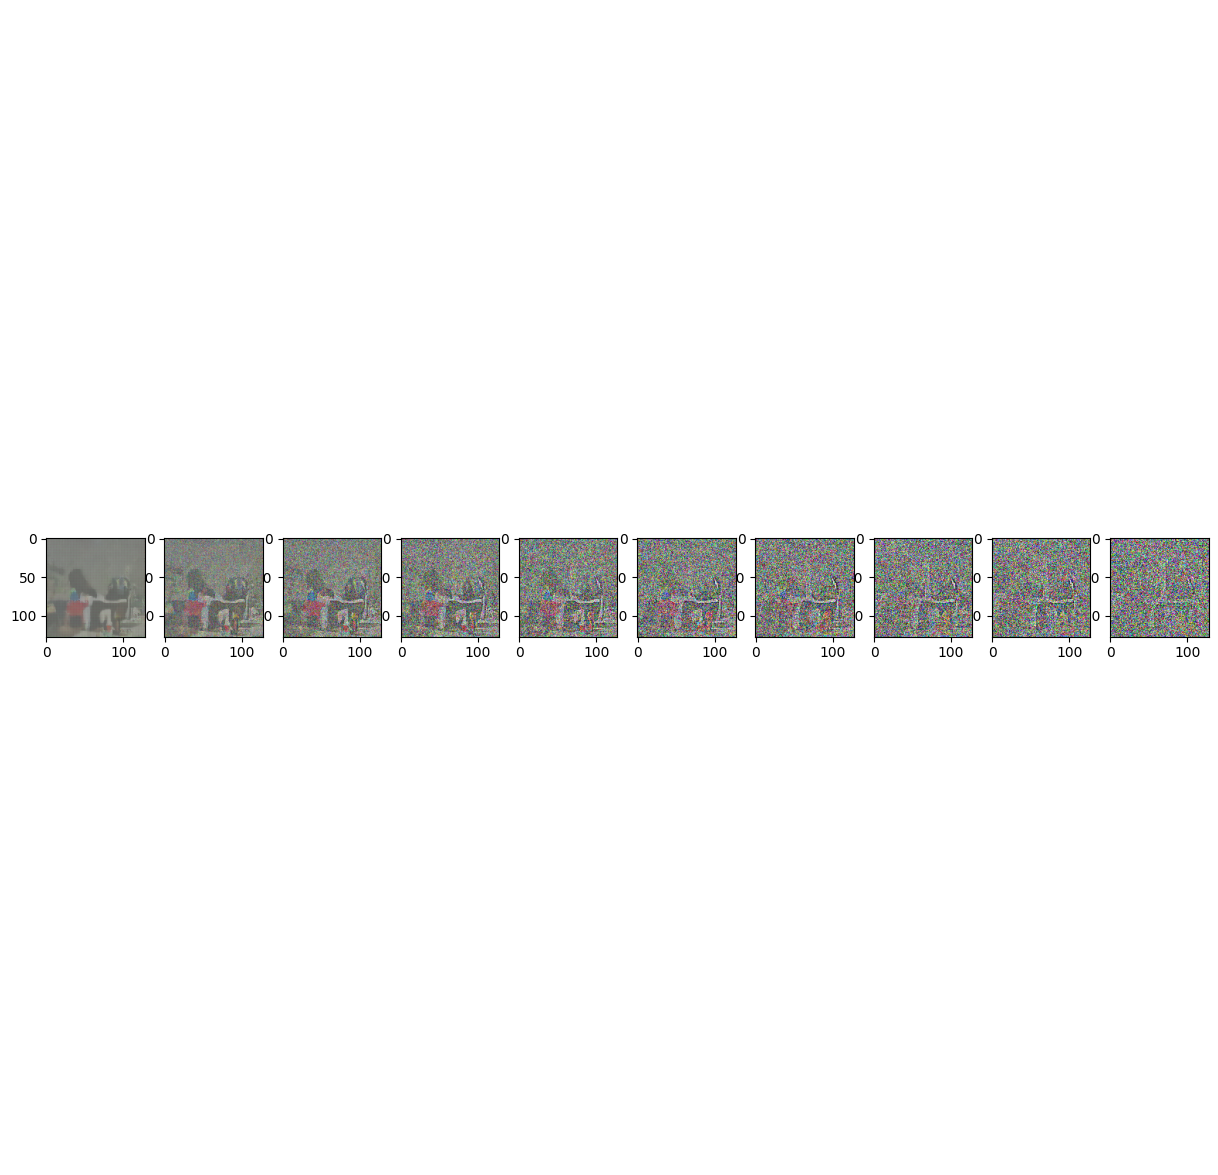

Epoch 95 | Loss: 0.14197972416877747 


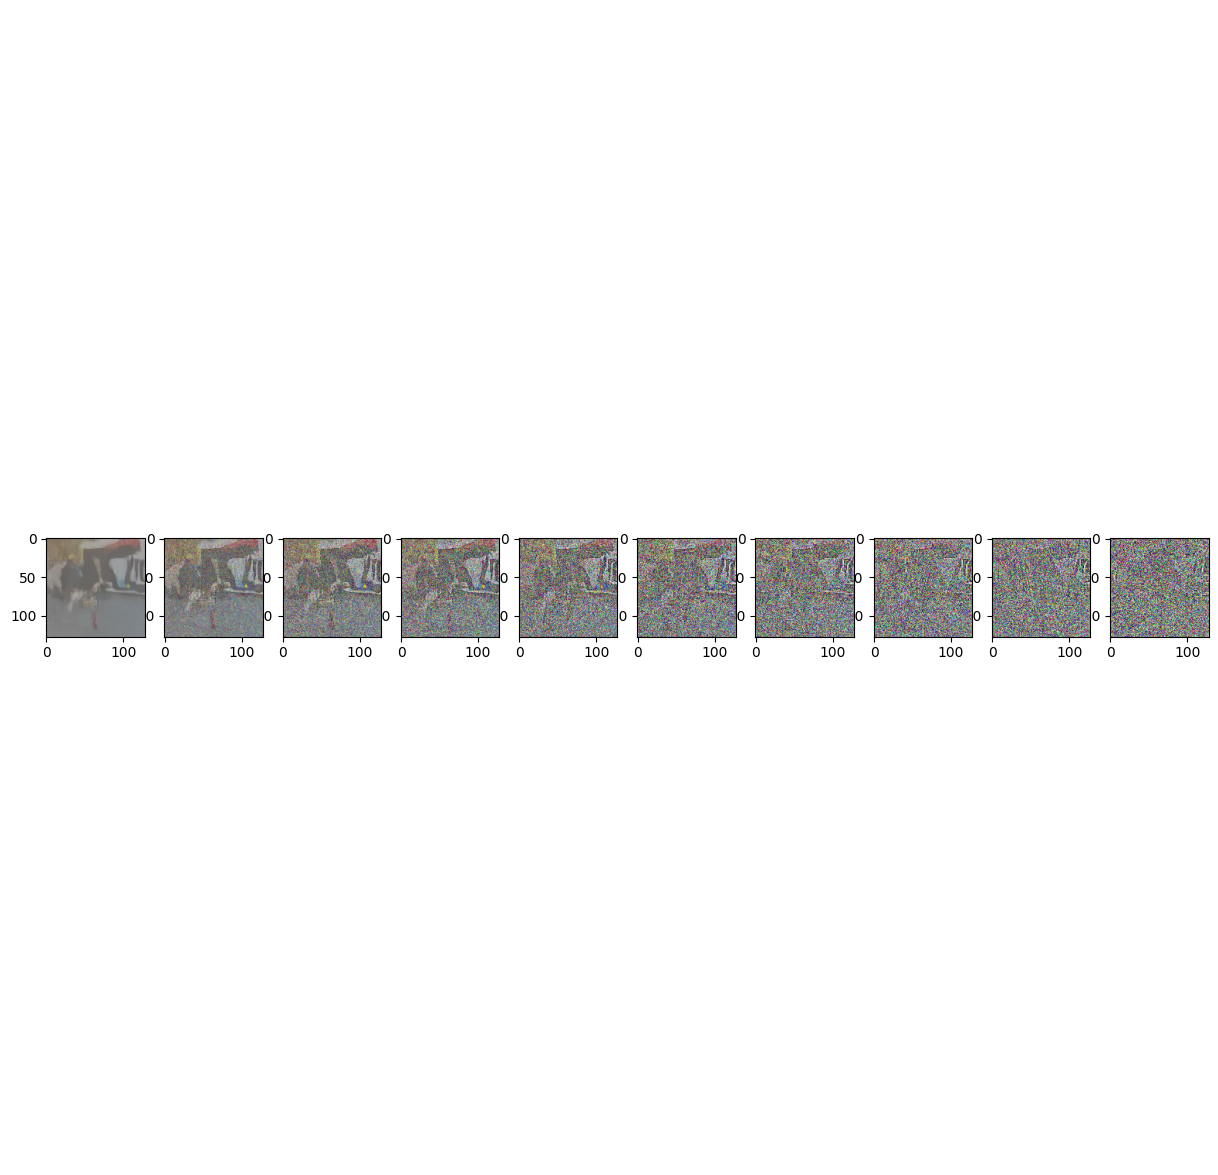

In [384]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
      music, image = batch
      music = music.to(device)
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, image, t, music)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()} ")
        sample_plot_image(music[0])

In [385]:
torch.save(model.state_dict(), 'diffusion_model_100.pth')